## Homework 2 : Clustering Gaussian Mixtures



**Reminder:** This time we will penalize excessively long answers, i.e. if you cannot answer a question with 1-5 sentences, you should think again.


In this homework you will perform Gibbs sampling on a Gaussian Mixture Model (GMM). You will compute the posterior distribution of a general Gaussian Mixture, generate data from it (a ground truth), sample the equilibrium distribution through Gibbs sampling and check if the retrieved model resembles the original one that truly generated your data.

**Note:** I have discussed with colleague Emil Spasov Spasov about certain results of the homework and we have worked together on some of the problems.

In [1]:
#Import the necessary packages. You may want to import other ones if needed.
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
np.random.seed(42)

## Exercise 1 (6 pt) - Theory Questions

In this first part we will recall concepts dealt in class and in the notes of the course, with small variations. Please refer to Chapter $8.1$ of the lecture notes for the full details on Clustering and the setting below.

Consider a set $X \in \mathbb{R}^{n \times d}$ of unlabelled data, i.e., a set of $n \in \mathbb{N}$ objects with $d \in \mathbb{N}$ features respectively.

The Loss function that a Gaussian Mixture Model (GMM) aims at minimizing is the following:
$$
    \mathcal{L}(U,V) := \frac{1}{n}\sum_{\mu=1}^n\sum_{i=1}^d \left( X_{\mu i } - \sum_{a=1}^k u_{a i} v_{\mu a} \right)^2
$$

where the vectors $v_\mu \in \mathbb{R}^k$ are the one-hot encoded representations of the clustering assignment of points, and $u_a \in \mathbb{R}^d$ are coordinates of the cluster centers.

The size of the clusters is encoded in the prior of the label assignments:

$$P_{v}(V) = \prod_{\mu=1}^n P_{v}(v_\mu) = \prod_{\mu=1}^n \left( \sum_{a=1}^k \pi_a\delta(e_a - v_\mu) \right)$$

where $\sum_a \pi_a = 1 $ ($\pi_a \in (0,1)$ are the fractions corresponding to the size of cluster $a$ and they are called weights and $e_a$ is a one-hot encoded vector of size $k$ which takes value 1 at the position $a$ and zero elsewhere).




In this setting, the important parameters that define our model are the cluster centers, the cluster assignments and the weights of each cluster. All these informations are encoded in the class GaussianMixture of the library sklearn, that is imported above.

**Question 1 (1 pt):** You are given an histogram of $n=4600$ points generated with 3 Gaussian distributions in $d=1$ dimensions. For this first question, create a Gaussian Mixture Model (GMM) from the package GMM and fit the points of the histogram.

Replot the histogram of raw points along with the fitted curve (GMM) and print the fitted values of the weights, the means and the covariances of the Gaussians found by the model.

Remark: in k-means and in GMM you have to specify the number of clusters.

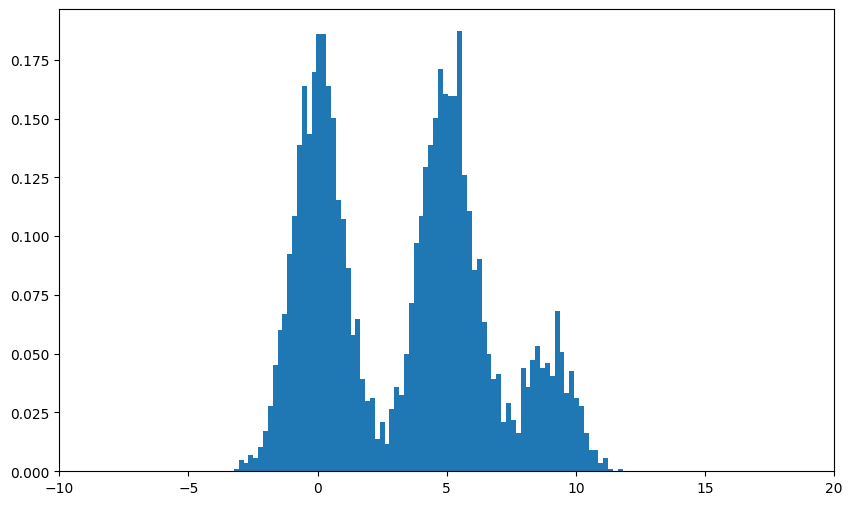

In [2]:
x = np.concatenate([np.random.normal(0, 1, 2000),
                    np.random.normal(5, 1, 2000),
                    np.random.normal(9, 1, 600)])     # concatenates the three gaussian-distributed vectors
x=x.reshape(-1,1)

plt.figure(figsize=(10, 6))
plt.hist(x, 80, density=True)                          # density=True normalizes the histogram
plt.xlim(-10, 20)
plt.show()

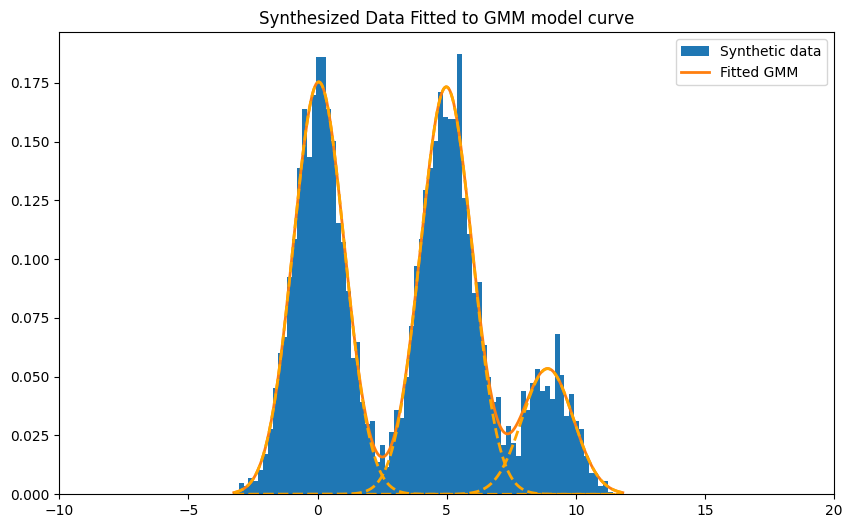

GMM Fit cluster weights: [0.43326164 0.13205806 0.4346803 ]
GMM Fit cluster means: [4.98336285 8.9093236  0.04511381]
GMM Fit cluster covariances: [0.99493571 0.97292019 0.97745714]


In [3]:
n = 4600; d = 1; means = [0, 5, 9]; covariances = [1, 1, 1]
weights = [2000/n, 2000/n, 600/n]; n_points = np.round(np.array(weights) * n).astype(int)

# Fitting procedure
gmm_model = GMM(n_components=3, random_state=42)
gmm_model.fit(x.reshape(-1, 1)) 

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(x, bins=80, density=True, label="Synthetic data")
x_values = np.linspace(min(x), max(x), 1000).reshape(-1, 1)
logprob = gmm_model.score_samples(x_values)
pdf = np.exp(logprob)  # Probability density function
plt.plot(x_values, pdf, label="Fitted GMM", linewidth=2)

for mean, cov, weight in zip(gmm_model.means_, gmm_model.covariances_, gmm_model.weights_):
    plt.plot(x_values, weight * (1 / np.sqrt(2 * np.pi * cov)) * np.exp(-0.5 * ((x_values - mean) ** 2) / cov),linestyle='--', color='orange', linewidth=2)

plt.title("Synthesized Data Fitted to GMM model curve")
plt.legend();plt.xlim(-10, 20);plt.show()

print(f"GMM Fit cluster weights: {gmm_model.weights_.flatten()}")
print(f"GMM Fit cluster means: {gmm_model.means_.flatten()}")
print(f"GMM Fit cluster covariances: {gmm_model.covariances_.flatten()}")


Note: for practical purposes you will use the function GMM. However, for the purpose of this homework you will have to write from scratch the functions needed in the following.

Now consider the following framework for generating synthetic data:

\begin{equation}
X_{\mu i} = \sqrt{\frac{\rho}{d}} \sum_{a=1}^k v^{*}_{\mu a} u^{*}_{ai} + \xi_\mu
\end{equation}

where $v^{*}_{\mu}$ is the ground-truth one-hot vector, encoding the cluster memberships of data-point $X_{\mu}$, while $u^{*}_{a}$ is the ground-truth centre of cluster $a$.
The additional term $ \xi_{\mu i} \sim \mathcal{N}(0,1)$ corresponds to the noise, here assumed to be the same for all clusters ($V \in \mathbb{R}^{n\times k}$, $U\in \mathbb{R}^{k\times d}$ and $\xi \in \mathbb{R}^{n \times d}$ are matrices!) . The factor $\frac{1}{\sqrt{d}}$ corresponds to the scaling for which the model behaves interestingly.

The parameter $\rho>0$ is called "signal-to-noise ratio" and indicates the relative fraction of the information you want to retrieve, in this case the cluster centers and the label assignment, with respect to the noise through which your data are corrupted.

The goal of the excercise is to infer the ground-truth,  that is the cluster centers $U^*$ and the cluster assignment of points $V^*$, given the noisy observations $X_{\mu i} $. We do it in a Bayesian setting.

**Question 2 (1 pt):** What do you expect to happen to the inference problem, i.e. recovering the true centres of clusters and the true labels of points, when $\rho$ is very small ? What do you expect to happen when $\rho$ is very large? What could happen for intermediate values of $\rho$ if the number of data and dimensions become very large and of comparable sizes, in particular $d,n\rightarrow \infty$ with $\alpha=n/d=o(1)$.

**_Answer_** : 

When $\rho$ is very small, it will be difficult to find the cluster centers since the data is has too much noise. Larger $\rho$ makes it easier because we have more signal than noise and the data points will cluster closely to each-other. 

As $d,n\to \infty$, we struggle to find true clusters because of the "curse of dimensionality".  As $\alpha = n/d = o(1)$, intermediate values of $\rho$ is crucial important. We need a sufficient/critical $\rho_c$ to have enough signal to recover labels and centers.

**Question 3 (2 pt):** Write the posterior distribution of the model. What is the value of the temperature $\Delta$ (recall lecture notes) here ?

Remark: In this first point the priors for the rows for each cluster $u_i \in \mathbb{R}^d$ are i.i.d., i.e. factorized over $i=1,...,d$ with a given as $P_{u}(u_i)$.

Similarly the label assignments $v_\mu \in \mathbb{R}^k$ are i.i.d. over $\mu=1,...,n$ and we use the general prior $P_{v}(v_\mu)$.

This leads to the posterior

**_Answer_** : 
- The posterior is found with the help of Bayes update rule
$$
P(U, V \mid X ) = \frac 1Z \prod_{\mu=1}^n \prod_{i=1}^d P_v(v_\mu)P_u(u_i) \exp\left({-\frac{n}{2\Delta}} \mathcal{L}(U,V)\right)
$$
$$
P(U, V \mid X )  = \frac 1Z P_v(V)P_u(U)  \prod_{\mu=1}^n \prod_{i=1}^d \exp \left[- \frac{1}{2\Delta}\left(X_{\mu i}- \sqrt{\frac \rho d} \sum_{a=1}^k u_{ia} v_{\mu a}\right)^2\ \right]
$$


where $P_v(V)$ is the size of the clusters encoded in the prior of the label assignments, $1/Z$ is the evidence, etc...

- From the lecture notes, the temperature $\Delta$ is same as noise variance. Since $\xi_\mu \sim  \mathcal{N}(0,1)$, then $\Delta = 1$


From now on, assume the distribution of the centers $u_{i}$ (for each cluster $a=1\dots k$) to be Gaussian with zero mean and unit variance. This means:
$$
P_u (u_i) = \frac{1}{(2\pi)^{k/2}}\exp(\frac{-||u_i||^{2}_{2}}{2}) = \prod_{a=1}^{k} \frac{1}{2\pi}\exp\Big(\frac{-u_{i a}^2}{2}\Big)
$$

Moreover, assume the labels are uniformly distributed, that is $\pi_{a}=\frac{1}{k}$ $\forall a$. This means:
$$
P_{v}(v_\mu) = \frac{1}{k} \left( \sum_{a=1}^k \delta(e_a - v_\mu) \right)
$$

Also assume the number of clusters k and the parameter $\rho$ are given. The only objective is to recover the matrices U and V.

**Question 4 (2 pt):** Write a function for generating GMM data in the format above, with all the assumptions on U and V. Generate the data $X_\mu$ with $n=300$ and $d=150$. Store the matrices U and V that you used for generating them as the ground-truth that you want to recover. Use $k=2$ clusters and $\rho=4$

Hint: you may want to take inspiration from the function in the Excercise session 7 but change it accordingly.

In [4]:
### Write your code here:
def generate_gmm_data(n, d, k, rho):
    """
    Params - n: samples, d: dimension of sample, k: clusters, rho: scaling
    Return - X: generated samples, U_true: true cluster center, V_true: one-hot encoded cluster assignments
    """
    U_true = np.random.normal(0, 1, (k, d))  # Distribution of the centers
    V_true = np.zeros((n, k))  # True cluster assignments
    V_true[np.arange(n), np.random.choice(k,n)]=1
    X = np.sqrt(rho/d) * (V_true@U_true)
    X+= np.random.normal(0,1,(n, d))
    return X, U_true, V_true

np.random.seed(42) 
d = 150; k=2; n=300; rho=4; X, U_true, V_true = generate_gmm_data(n,d,k,rho) # Generated Xµ, and ground truth U*, V*

## Exercise 2 (10 pt) - Gibbs Sampling

For now let's forget about the ground truth $U^*$ and $V^*$. Just keep in mind the data $X$ you generated and the values of $k$, $\rho$ and $d$.

The objective of this exercise is to sample from the posterior distribution identified earlier, using Gibbs sampling. Gibbs sampling is advantageous here because it adapts well to continuous variables, and simplifies the sampling process by breaking it down into scalar values through the use of conditional probabilities.

In all this setting keep in mind the posterior distribution you derived before, as well as the priors for the cluster centers and the label assignments:
$$
P_u (u_i) = \frac{1}{(2\pi)^{k/2}}\exp \left(\frac{-||u_i||^{2}_{2}}{2}\right)
$$
and
$$
P_{v}(v_\mu) = \frac{1}{k} \left( \sum_{a=1}^k \delta(e_a - v_\mu) \right)
$$




**Question 1 (6 pt):** In this question we write and code the Gibbs Sampling algorithm for GMM.

Note that in this problem the matrices that you want to reconstruct, are $U$ and $V$ (instead of just a single one as in the spin glass game). For this reason, the main focus of Gibbs sampling are the **two** conditional probabilities

 $$P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X)$$

 and

$$P(v_{\mu a}|\{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X).$$

For the purpose of the derivation you will keep the notation general and then, when you will run your code, fix the values $k=2$, $d=150 $, $n=300 $, $\rho=4$


Derivation of the Gibbs sampling.

**A)** Derive the likelihood (Note, highlight only the interesting terms, i.e. the one(s) depending explicitely on $u_{ia}$ and $v_{\mu a}$ and just write $\propto$ for hiding the ones that are constant in both)

$$
P(X \mid U,V) \propto \dots
$$

> Answer 

The likelihood can be extracted from the posterior, and depends on $u_{ia}$ and $v_{\mu a}$ according to GMM model:
$$
P(X \mid U,V) \propto \prod_{\mu = 1}^n \prod_{i=1}^d \exp \left[-\frac{1}{2}\left(X_{\mu i}- \sqrt{\frac{\rho}{d}} \sum_{a=1}^k u_{ia} v_{\mu a} \right)^2 \right]
$$.

**B)** Since we defined $P_{u}(u_{ai})=\frac{1}{\sqrt{2\pi}}e^{-\frac{u^{2}_{ai}}{2}} $ you can derive the following simple factorization:
$$
P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) \propto \dots
$$
> Answer:

We know from Bayes rule that $P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) \propto P(X|U,V)P_u(u_{ai})$, such that we simply get

$$
P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) \propto \exp \left[-\frac{1}{2}\left(X_{\mu i}- \sqrt{\frac{\rho}{d}} \sum_{a=1}^k u_{ia} v_{\mu a} \right)^2 -\frac{u_{ai}^2}{2} \right] =  \exp \left[- \frac 12 \frac {\left(u_{ai} - \sqrt{\frac \rho d}\frac{\sum_{\mu=1}^n Z_{\mu i} v_{\mu a}}{\sum_{\mu=1}^n v_{\mu a}+1}\right)^2}{\frac{d}{\rho} \sum_{\mu=1}^n v_{\mu a}+1} \right]
$$

where we defined some local field $Z_{\mu i} = X_{\mu i}- \sqrt{\frac{\rho}{d}}\sum_{a'\neq a}u_{a'i}v_{\mu a'}$, and also $v_{\mu a}^2 = v_{\mu a}$ thanks to the one-hot encoding structure of $V$. This is clearly a Gaussian form.


**C)** At the end of the previous derivation, you should obtain a form that shows that that the conditional distribution for the cluster centres $u_{ai}$ are Gaussian with certain means $\mu_{ai}$ and variances $\sigma^{2}_{ai}$ that depend on $\rho$, $v_{\mu a}, Z_{\mu i}$ and $d$.

So, finally, you can obtain that

$$
P(u_{ai}|\{u_{a'i'}\}_{a'\neq a,i'\neq i} , V, X) = \mathcal{N}(\mu_{ai},\sigma^{2}_{ai})
$$
with $Z_{\mu i} = X_{\mu i}- \sqrt{\frac{\rho}{d}}\sum_{a'\neq a}u_{a'i}v_{\mu a'}$ and:


> Answer:

$$
\mu_{ai} = \sqrt{\frac \rho d}\frac{\sum_{\mu=1}^n Z_{\mu i} v_{\mu a}}{\sum_{\mu=1}^n v_{\mu a}+1}
$$

$$
\sigma^{2}_{ai} = \frac{d}{\rho} \frac{1}{\sum_{\mu=1}^n v_{\mu a}+1}
$$

**D)** Regarding the label assignment $P(v_{\mu a}|\{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X)$, compute:

$$
P(v_{\mu a}=1 \mid \{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X) = \dots
$$

>Answer:

Again, the Bayes' theorem gives the update rule

$$
P(v_{\mu a}=1 \mid \{v_{\mu'a'}\}_{\mu'\neq \mu,a'\neq a} , U, X) = \frac{P(X\mid v_{\mu a} = 1,U)P(v_{\mu a}=1\mid \{v_{\mu' a'}\}_{\mu' \neq \mu, a'\neq a})}{P(X \mid  \{ v_{\mu' a'} \}_{\mu' \neq \mu, a'\neq a}, U ,V)}
$$

Hint: Use the fact that $v_{\mu a}=1$ automatically implies $v_{\mu a'}=0$ $\forall a' \neq a$ thanks to the one-hot encoding structure of $V$.
Hence:

\begin{equation}
P(v_{\mu a}=1 \mid  U, X) = \dots 
\end{equation}

>Answer:

All the other $v_{\mu a'}$ vanish, so we simply end up with a neat soft-max function
$$
P(v_{\mu a}=1 \mid  U, X) = \frac{\exp(-\frac{1}{2} \sum_{i=1}^d(X_{\mu i}-\sqrt{\frac \rho d} u_{ai})^2)}{\sum_{a'\neq a}\exp(-\frac{1}{2} \sum_{i=1}^d(X_{\mu i}-\sqrt{\frac \rho d} u_{a'i})^2)}
$$


**E)** Finally, write code to simulate Gibbs sampling given the conditional distributions above.
Recall the steps of the Gibbs sampling, and adapt to this problem:

0) Set $k=2$, $d=150 $, $n=300 $, $\rho=4$ and generate your data X accordingly, with some ground truth $U^*$ and $V^*$

1) Initialize $t=0$, $U_{t=0}$ and $V_{t=0}$. We recall U is Gaussian distributed with mean zero and unit variance. V is uniformly distributed in the one-hot encoded configurations for each row.

2) Sample alternatively from the two conditional distributions above for $T=2000 $ steps. Be sure to reach equilibrium.

3) Store at each iteration the value of the GMM Loss, the values of $U_{t}$ and $V_{t}$.

4) Compute, at each iteration, the ErrorRate defined as the fraction of correctly labeled points:
<!--  -->
$$
ErrorRate = \frac{1}{n}Tr(V_{Gibbs,t}^{T}V^{*})
$$
Where $V_{Gibbs,t}$ is the estimate of the gibbs matrix at time $t$.
This quantity ranges from $1/k$, i.e. random guessing, to 1, i.e. perfect recovery of the ground truth.
From the error rate compute the Overlap:

$$
Overlap = \frac{ErrorRate-1/k}{1-1/k}
$$
In this way the overlap is a quantity between 0 and 1.

Note: in the Gibbs sampling function, add an option to initialise the matrices $U$ and $V$ at $t=0$ randomly, but also in the ground truth values $U^*$ and $V^*$. Of course, this second option is not practical since in principle we do not know the ground truth and we want to retreive it. However, it is useful as a check for theoretical purposes, as seen in Tutorial $6$.

In [ ]:
### Write your code here.
def compute_error_rate(V_est, V_true):
    """
    Compute the error rate between estimated and true cluster assignments.
    """
    n = V_true.shape[0]
    # Convert one-hot encodings to label indices
    labels_true = np.argmax(V_true, axis=1)
    labels_est = np.argmax(V_est, axis=1)

    # Compute the contingency matrix
    contingency_matrix = np.zeros((V_est.shape[1], V_true.shape[1]), dtype=int)
    for i in range(n):
        contingency_matrix[labels_est[i], labels_true[i]] += 1

    # Apply the Hungarian algorithm to find the best mapping
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Compute the total number of correct assignments
    total_correct = contingency_matrix[row_ind, col_ind].sum()
    E = 1 - total_correct / n
    return E 

def sample_U(X, V, beta):
    """
    Sample U given V and X.
    """
    n, d = X.shape; k = V.shape[1]
    N = V.sum(axis=0)  # Sum over all labels
    S = V.T @ X  # Effective field
    A = 1 + beta * N  # Denominator
    mu = (np.sqrt(beta) * S) / A[:, np.newaxis]  # mean
    variance = 1 / A  # variance
    U = mu + np.random.randn(k, d) * np.sqrt(variance)[:, np.newaxis] # sampling from gaussian
    return U

def sample_V(X, U, beta):
    """
    Sample V given U and X.
    """
    n, _ = X.shape
    k, _ = U.shape
    V = np.zeros((n, k))
  
    log_p = -0.5 * np.sum((X[:, np.newaxis, :] - (np.sqrt(beta) * U)[np.newaxis, :, :]) ** 2, axis=2)
    log_p -= np.max(log_p, axis=1, keepdims=True)
    p = np.exp(log_p)
    p /= np.sum(p, axis=1, keepdims=True)
    rand_vals = np.random.rand(n, 1)
    cum_dist = np.cumsum(p, axis=1) #cumulative distribution
    assignments = (rand_vals < cum_dist).argmax(axis=1)
    ###############
    V[np.arange(n), assignments] = 1
    return V


def compute_loss(X, U, V, beta):
    """
    Compute the loss function

    returns a floating point value
    """
    n,d=X.shape
    X_estimated = np.sqrt(beta)*V@U # Estimating ground truth
    loss = np.sum((X - X_estimated ) ** 2)/n # square distance as shown in formula
    return loss

def compute_overlap(V_est, V_true, k):
    """
    Compute the overlap between estimated and true cluster assignments.

    returns a floating point value

    """
    error_rate = compute_error_rate(V_est, V_true)
    overlap = 1 - error_rate
    return overlap

def gibbs_sampling(X, k, rho, T, U_true, V_true, init):
    """
    Perform Gibbs sampling.
    """
    n, d = X.shape
    beta = rho/d
    # Initialize U and V
    if init == 'random':
        U = np.random.normal(0, 1, (k, d)) #sampling from normal dist
        V = np.zeros((n, k))
        V[np.arange(n), np.random.choice(k,n)] = 1 # just random assignment
            
    elif init == 'informed':
        U = U_true.copy() #we just copy "ground truth"
        V = V_true.copy()
    else:
        raise ValueError("Invalid init value or V_true not provided for 'informed' init")

    Loss_history = np.zeros(T)
    Overlap_history = np.zeros(T)

    for t in range(T):
        U_new = sample_U(X, V, beta)  # Update U
        U=U_new
        V_new = sample_V(X, U, beta)  # Update V
        V=V_new
       
        loss = compute_loss(X, U, V, beta)
        Loss_history[t] = loss

        if V_true is not None:
            Overlap_history[t] = compute_overlap(V, V_true, k)
        else:
            Overlap_history[t] = 0

    return Loss_history, Overlap_history, U, V

**Question 2 (1 pt):** Sample from the Gibbs algorithm T=2000 steps and plot the loss function of the GMM model with respect to time.

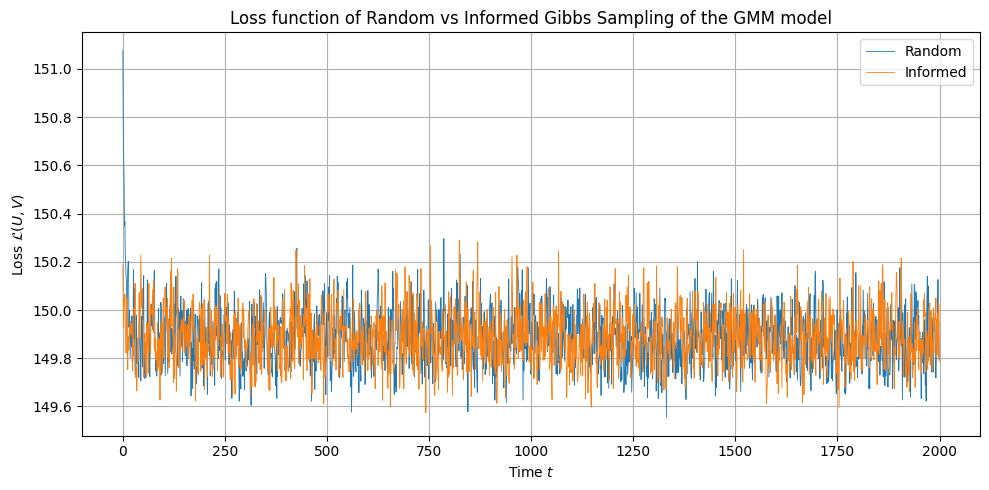

In [206]:
###Write your code here
d =150 ; k=2; n=300; rho=4; T=2000
X, U_true, V_true = generate_gmm_data(n, d, k, rho) # GMM sythetic data :)
Loss_rand, Overlap_rand, U_rand, V_rand= gibbs_sampling(X, k, rho, T, U_true=U_true, V_true=V_true, init='random')
Loss_informed, Overlap_informed, U_informed, V_informed= gibbs_sampling(X, k, rho, T, U_true=U_true, V_true=V_true, init='informed')

plt.figure(figsize=(10, 5)); plt.title("Loss function of Random vs Informed Gibbs Sampling of the GMM model")
plt.plot(range(T), Loss_rand, linewidth= 0.6, label="Random"); plt.plot(range(T), Loss_informed, linewidth= 0.6, label="Informed")
plt.xlabel(r"Time $t$"); plt.ylabel(r"Loss $\mathcal{L}(U,V)$");plt.tight_layout();plt.grid();plt.legend();plt.show()

**Comment:** The loss converges proportionally to $d$, meaning that higher dimension -> harder to label and assign clusters. Curse of dimensionality!

**Question 3 (1 pt):** Store the values $U_{t}$ and $V_{t}$ during Gibbs sampling. Compute the overlap of the labels assignment with respect to the ground truth from the formula above.


Plot the Ovelap with respect to the Gibbs sampling iterations. Distinguish two cases, to show in the same plot:

1) Random initialization of $U_{t=0}$ and $V_{t=0}$ (in blue);

2) Informed initialization of $U_{t=0}=U^*$ and $V_{t=0}=V^*$ to the ground truth, i.e. $U_{t=0}$ and $V_{t=0}$ (in orange).

Important note : the ground truth is never known in practice and thus you simply cannot use it. For practical applications you always have to initialize randomly (blue curve). However, for the scope of the excercise and following what has been done in the tutorials, you can see the difference when initializing directly to the correct values (orange curve).

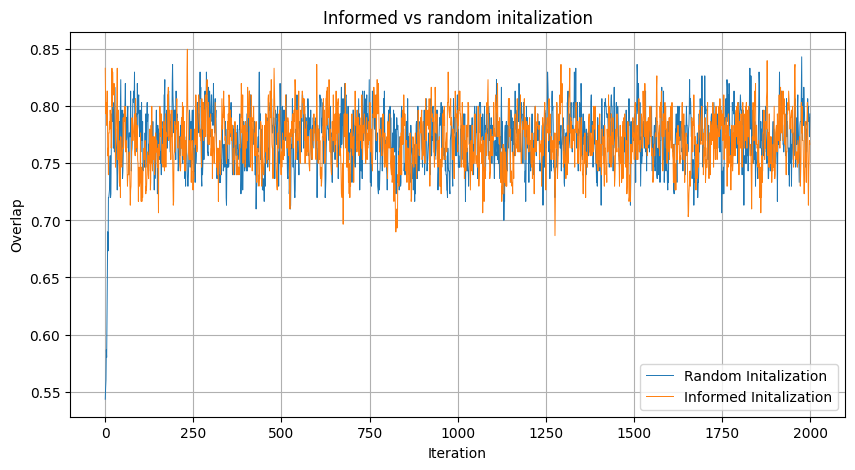

In [207]:
### Write your code here
plt.figure(figsize=(10, 5))
plt.title("Informed vs random initalization")
plt.plot(range(T), np.abs(Overlap_rand), label="Random Initalization", linewidth=0.7)
plt.plot(range(T), Overlap_informed, label="Informed Initalization", linewidth=0.7)
plt.ylabel("Overlap")
plt.xlabel("Iteration")
plt.legend()
plt.grid()
plt.show()

**Comment:** It is apparent for an MCMC that random initializations very quickly converges, since we have well behaved posterior and unit variance in the noise $\xi_\mu$

**Question 4 (1 pt):** Take $n=300$, $d=150$, $k=2$, $T = 1000$. Run Gibbs sampling with random initialization varying the parameter $\rho$ from 0 to 4 at steps of 0.1. For each value of rho, compute the mean overlap in the last steps (choose an appropriate value for convergence, same for T) and take also $n_{sim}=5$ different simulations in order to compute the standard deviation (in this question you are allowed to change the seed).

Plot the overlap with respect to the values of $\rho$ with error bars along the y-axis. Comment briefly the result.



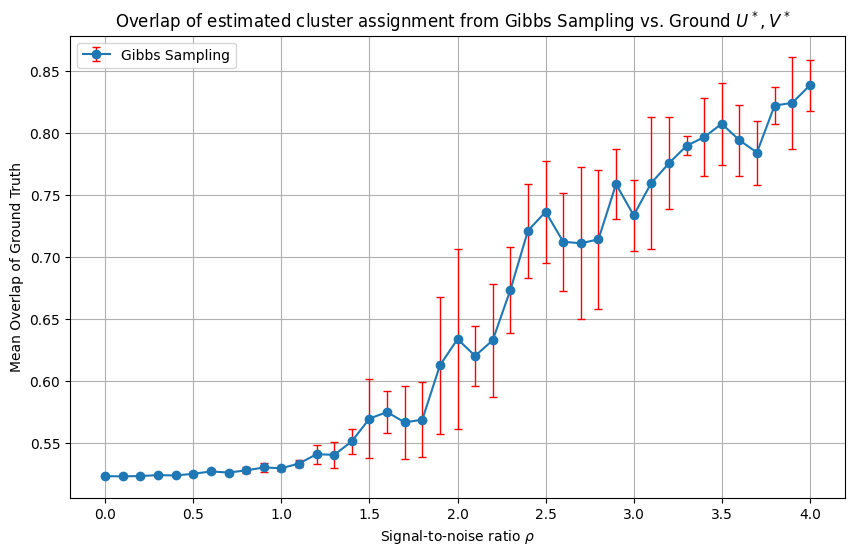

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_overlap = []; std_overlap = []
rho_values = np.arange(0, 4.1, 0.1)
n_sim = 5
n = 300
d = 150
k = 2
T = 1000

for rho in rho_values:
    overlap_simulations = []
    for sim in range(n_sim):
        np.random.seed(sim + int(rho * 100))  # we change the seed each run
        X, U_true, V_true = generate_gmm_data(n, d, k, rho)
        Loss_history, Overlap_history, U, V = gibbs_sampling(X, k, rho, T=T, U_true=U_true, V_true=V_true, init='random')
        last_overlap = np.mean(Overlap_history[-800:]) # i choose covergence time T=800
        overlap_simulations.append(last_overlap)
    mean_overlap.append(np.mean(overlap_simulations))
    std_overlap.append(np.std(overlap_simulations))

# Plotting
plt.figure(figsize=(10, 6))
plt.title(r"Overlap of estimated cluster assignment from Gibbs Sampling vs. Ground Truth $U^*, V^*$  ")
plt.errorbar(rho_values,mean_overlap,yerr=std_overlap,fmt='-o',capsize=3,ecolor='red',elinewidth=1,markeredgewidth=1,label='Gibbs Sampling')
plt.xlabel(r"Signal-to-noise ratio $\rho$"); plt.ylabel("Mean Overlap of Ground Truth")
plt.grid(); plt.legend();plt.show()


**Answer**: <br>
As $\rho$ increases, the signal dominates the noise, and we can reconstruct X good and we get very good overlap, up to almost $85\%$. <br>
We see that if $\rho$ is less than the noise variance $\rho < \sigma^2 =1$, the model struggles to label the clusters and it seems like it can label correctly 50/50 like flipping a coin. <br>
The mean overlap stays at 50% until the we have enough signal ($\rho$ is large enough/reaches some critical point) then the model improves drastically as $\rho$ increases

**Question 5 (1 pt):** Now increase $n$ and $d$, in particular take $n=1500$, $d=1500$, $k=2$, $T=2000$, $\rho=3$. Compute and print the value of the overlap in two different ways:

1) Fit a K-means algorithm on the $X$ data, you can use existing libaries in sklearn. Compute the overlap between the original ground truth and the labels found by K-means.

2) with the previous Gibbs algorithm, just print the last value.



In both cases, run $n_{sim}=3$ simulations and print the two overlaps in the format $mean \pm std$.

Print these two values and compare them.


In [ ]:
from sklearn.cluster import KMeans
np.random.seed(42) #fix this for reproducibility
### Write your code here

n = 1500;d = 1500
k = 2;T = 2000
rho = 3; n_sim = 3
gibbs_overlaps = []
kmeans_overlaps = []

# Gibbs Sampling Overlap
for run in range(n_sim):
    random_state = run
    np.random.seed(random_state)
    # Generate data
    X, U_true, V_true = generate_gmm_data(n, d, k, rho)

    # Run Gibbs Sampling without loss calculation
    _, overlap_history, _, V_gibbs = gibbs_sampling(X, k, rho,U_true=U_true, V_true=V_true, T=T,init="random")
    overlap_gibbs = overlap_history[-1]
    gibbs_overlaps.append(overlap_gibbs)

# Compute Mean and Std for Gibbs Sampling
mean_overlap = np.mean(gibbs_overlaps)
std_overlap = np.std(gibbs_overlaps)

print(f"\nGibbs Sampling Overlap: Mean = {mean_overlap:.4f}, Std = {std_overlap:.4f}")

print("----")

for run in range(n_sim):
    # Set a different random state for each run
    random_state = run  # Or use None for completely random initialization
    np.random.seed(random_state)
    X, U_true, V_true = generate_gmm_data(n, d, k, rho)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(X)
    V_kmeans = np.zeros((n, k))
    V_kmeans[np.arange(n), kmeans_labels] = 1
    overlap_kmeans = compute_overlap(V_kmeans, V_true, k)
    kmeans_overlaps.append(overlap_kmeans)

# Compute Mean and Std for K-Means
mean_overlap_kmeans = np.mean(kmeans_overlaps)
std_overlap_kmeans = np.std(kmeans_overlaps)

print(f"\nK-Means Overlap: Mean = {mean_overlap_kmeans:.4f}, Std = {std_overlap_kmeans:.4f}")


Gibbs Sampling Overlap: Mean = 0.6858, Std = 0.0161
----

K-Means Overlap: Mean = 0.5649, Std = 0.0184


_Answer_ : <br>
When $d=1500$, it is very hard to separate clusters, still pretty okay results. In both results, standard deviation is quite small, meaning both methods are stable with enough signal-to-noise, but Gibbs still infers the cluster better by using Bayes update rule.
1. K-means $\approx 0.5 \propto 1/k$, inversely proportional to number of clusters, as expected in very high dimensions, it cannot tell apart clusters. <br>
2. Gibbs Sampling has higher mean overlap even with $d=1500$, because we sample the posterior of GMM which makes it much easier recover "ground truth" cluster assignments by means of Bayesian inference.<br>
